In [1]:
import sys
from pathlib import Path

# Add the project root directory to Python path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [14]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForLanguageModeling

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
import torch
from datasets import load_dataset

from config import MODEL_ID, USE_4BIT, LORA_CONFIG, BNB_4BIT_CONFIG, TRUST_REMOTE_CODE, DATA_PATH, TRAINING_ARGS, MODELS_PATH
from utils.data_preparation_utils import tokenize, format_to_messages

import pandas as pd
import matplotlib.pyplot as plt

model_id = MODEL_ID
lora_config = LoraConfig(**LORA_CONFIG)

### 🧩 Create Data Collator

The `DataCollatorForLanguageModeling` does:
- Converts tokenized examples into batches
- Generates:
  - `input_ids`: full prompt including answer
  - `labels`: target tokens (with prompt tokens masked as -100)
  - `attention_mask`: marks attention flow
This ensures that only the assistant part is used for computing the loss.


In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=TRUST_REMOTE_CODE)
collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

if USE_4BIT:
    bnb_config = BitsAndBytesConfig(**{
        **BNB_4BIT_CONFIG,
        "bnb_4bit_compute_dtype": getattr(torch, BNB_4BIT_CONFIG["bnb_4bit_compute_dtype"])
    })
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        torch_dtype="auto",
        trust_remote_code=True,
        quantization_config=bnb_config
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        torch_dtype=torch.float16,
        trust_remote_code=True
    )

tokenizer_config.json:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

c:\Users\pbori\Documents\ML AI Courses\Homework\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pbori\.cache\huggingface\hub\models--deepseek-ai--DeepSeek-R1-0528-Qwen3-8B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/859 [00:00<?, ?B/s]

Unrecognized keys in `rope_scaling` for 'rope_type'='yarn': {'attn_factor'}


model.safetensors.index.json:   0%|          | 0.00/33.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/7.77G [00:00<?, ?B/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.61G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
if USE_4BIT:
    model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 3,833,856 || all params: 8,194,569,216 || trainable%: 0.0468


In [6]:
training_args = TrainingArguments(
    output_dir="../models",                   # save path
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    logging_dir="../logs",                    # logs for TensorBoard
    logging_steps=5,                          # log every 5 steps
    save_steps=50,                             # save model every 50 steps
    save_total_limit=2,                       # save only 2 checkpoints
    report_to="tensorboard",                  # log to TensorBoard
    disable_tqdm=False,                       # show progress bar in Jupyter
    logging_first_step=True,                  # log on the first step
    lr_scheduler_type="cosine",
    warmup_steps=10,
    learning_rate=1e-4,
    eval_steps=50,
    save_strategy="steps",
    fp16=True,                                # enable 16-bit mode if available
)

In [7]:
dataset_path = DATA_PATH/ "Samples ChatGPT" / "train_teacher_deduplicated.jsonl"
dataset = load_dataset("json", data_files=str(dataset_path), split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
dataset = dataset.map(format_to_messages)
tokenized_dataset = dataset.map(lambda x: tokenize(x, tokenizer), remove_columns=dataset.column_names)

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

In [9]:
trainer = Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=collator
)


C:\Users\pbori\AppData\Local\Temp\ipykernel_31564\4063339520.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [10]:
trainer.train(resume_from_checkpoint=True)

	eval_steps: 50 (from args) != 500 (from trainer_state.json)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
c:\Users\pbori\Documents\ML AI Courses\Homework\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
5,1.628500
10,1.628700
15,1.285500
20,1.017800
25,0.976800
30,0.693900
35,0.605400
40,0.568200
45,0.549900
50,0.531000


Unrecognized keys in `rope_scaling` for 'rope_type'='yarn': {'attn_factor'}
c:\Users\pbori\Documents\ML AI Courses\Homework\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=71, training_loss=0.7498996450867451, metrics={'train_runtime': 147910.1209, 'train_samples_per_second': 0.008, 'train_steps_per_second': 0.0, 'total_flos': 2.663089947205632e+16, 'train_loss': 0.7498996450867451, 'epoch': 3.0})

In [11]:
pd.DataFrame(trainer.state.log_history)

,epoch,grad_norm,learning_rate,loss,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.000000,0.825529,0.000000,1.7599,1,NaN,NaN,NaN,NaN,NaN
1,0.212766,0.715504,0.000080,1.6285,5,NaN,NaN,NaN,NaN,NaN
2,0.425532,0.924897,0.000180,1.6287,10,NaN,NaN,NaN,NaN,NaN
3,0.638298,0.718876,0.000198,1.2855,15,NaN,NaN,NaN,NaN,NaN
4,0.851064,0.732996,0.000190,1.0178,20,NaN,NaN,NaN,NaN,NaN
5,1.085106,0.690639,0.000176,0.9768,25,NaN,NaN,NaN,NaN,NaN
6,1.297872,0.663573,0.000157,0.6939,30,NaN,NaN,NaN,NaN,NaN
7,1.510638,0.598738,0.000135,0.6054,35,NaN,NaN,NaN,NaN,NaN
8,1.723404,0.588360,0.000110,0.5682,40,NaN,NaN,NaN,NaN,NaN
9,1.936170,0.426462,0.000085,0.5499,45,NaN,NaN,NaN,NaN,NaN


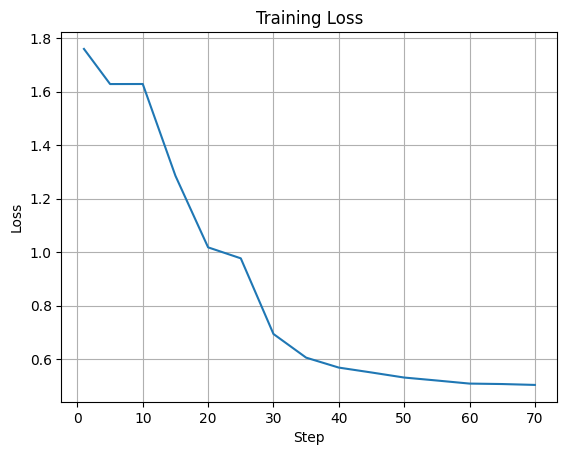

In [12]:
logs = pd.DataFrame(trainer.state.log_history)
plt.plot(logs["step"], logs["loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


In [ ]:
model_path = MODEL_PATH / "qwen-lora-finetuned"


model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


Unrecognized keys in `rope_scaling` for 'rope_type'='yarn': {'attn_factor'}


('../models/qwen-lora-finetuned\\tokenizer_config.json',
 '../models/qwen-lora-finetuned\\special_tokens_map.json',
 '../models/qwen-lora-finetuned\\chat_template.jinja',
 '../models/qwen-lora-finetuned\\tokenizer.json')